# Implementing a linear model and deep neural net from scratch
## Titanic Kaggle Competition

### Setting up the environment and downloading data
Setting up environement and kaggle API either for google colab or local machine, and downloading the dataset

In [7]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
  colab_flag = True
else:
  colab_flag = False

if colab_flag == True:
   print("Running in Colab...")
   #Install Kaggle API
   ! pip install -q kaggle
   #Install Huggingface Datasets lib
   ! pip install -q datasets
   #Install Huggingface transformers & the sentencepiece
   ! pip install -q transformers[sentencepiece,torch]
   print("...Installed required dependencies")
else:
   print("Assuming running in local environment...")

Assuming running in local environment...


In [2]:
if colab_flag == True:
  import json
  from google.colab import drive
  drive.mount('/content/drive/')

  # Set the file path
  file_path = '/content/drive/MyDrive/dtu/fastAI/04_NLP/kaggle_api.json'

  # Check if the file exists
  if os.path.exists(file_path):
      # Load the JSON file
      with open(file_path) as f:
          creds = json.load(f)
      print('Sucesfully set kaggle credentials')
  else:
      # Handle the case when the file does not exist
      creds = None  # or any other appropriate action you want to take
      print('Error: File not found, Credentials NOT set')
else:
    import json
    file_path = "../secrets/kaggle_api.json"
    # Check if the file exists
    if os.path.exists(file_path):
        # Load the JSON file
        with open(file_path) as f:
            creds = json.load(f)
        print('Sucesfully set kaggle credentials')
    else:
        # Handle the case when the file does not exist
        creds = None  # or any other appropriate action you want to take
        print('Error: File not found, Credentials NOT set')

Sucesfully set kaggle credentials


In [8]:
#using `pathlib.Path to work with paths in Python`
from pathlib import Path
#Set path for the titanic dataset
path = Path('titanic')

if path.exists():
  print('Data folder exists')
else:
  print('Data not detected, starting download')
  #Setup of kaggle credentials to use the API for downloading dataset
  cred_path = Path('~/.kaggle/kaggle.json').expanduser()
  if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(json.dumps(creds))
    #If not Json
    #cred_path.write_text(creds)
    cred_path.chmod(0o600)
  import zipfile,kaggle
  #Download data
  kaggle.api.competition_download_cli(str(path))
  #Unzip at path
  zipfile.ZipFile(f'{path}.zip').extractall(path)

#Verifying the the local content
!ls {path}

Data folder exists
gender_submission.csv  test.csv  train.csv


In [9]:
import torch, numpy as np, pandas as pd

In [10]:
#Recomended tweaks for display settings 
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

## Cleaning the data

In [274]:
df = pd.read_csv('titanic/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Check for empty values

In [275]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

One way to replace NaN values is simply to set it to the most common value, the Mode. Mode returns the most common value, but if there are 2 or more equally common values, it will return a list of these values - therefore we use iloc[0] to grab only the first element of the list.

In [276]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

We now fill all NaN values with the mode of the column.

In [277]:
df.fillna(modes, inplace=True)


In [278]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

A quick description of the data


In [279]:
#Specifying include = np.number filters the DF to only display columns that have numeric data types
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


It can  be seen that some columns such as fare has a very high max compared to the mean of the variable

<Axes: >

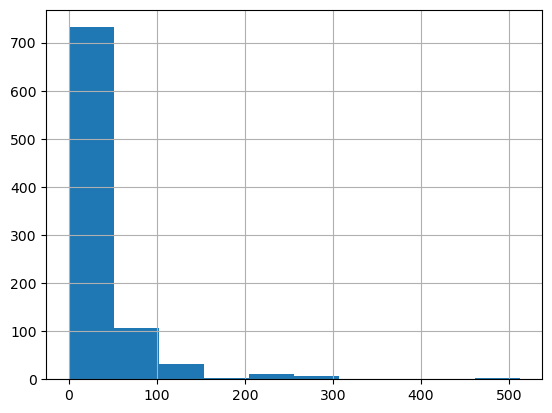

In [280]:
df['Fare'].hist()

This is a so called long-tail distribution and is often seen in relation to income, where a few people have a very high income, and the majority has a lower income. This might scew the model, and a common way to deal with this is to take the log of the variable.

<Axes: >

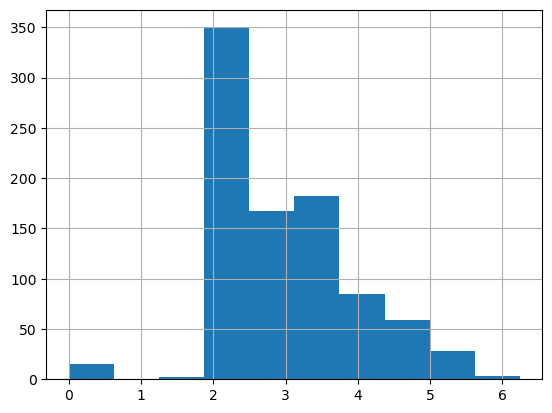

In [281]:
df['Logfare'] = np.log(df['Fare']+1)
#Adding 1 to the fare to avoid log(0) error
df['Logfare'].hist()

<Axes: >

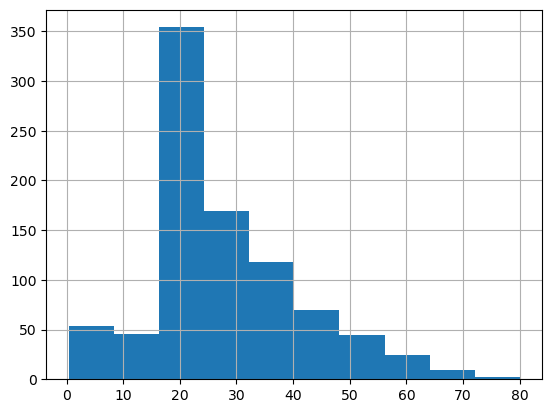

In [282]:
#Visualising a few of the columns
df['Age'].hist()

It can be seen that especially the age column and fare have relatively high values to the remainder of the data, we will normalize the relevant dater later on once we have selected the features we want to use.

### Summary of the non-numeric columns


In [283]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


Since we can't input strings to our numerical, linear model, we will instead encode the non numeric values as dummy variables (also called one-hot encoding). This means that we create a new column for each unique value in the column, and set the value to 1 if the row has that value, and 0 otherwise. We will leave out the columns name, cabin and ticket, since these have too many unique values.

In [284]:
#get_dummies will automatically create dummies and remove the original columns
#Drop first is optional but will remove the first dummy column to avoid multicollinearity, i.e. the first dummy column can be inferred from the others
#However dropping the column require that one adds a constant to the model

#dtype to set dummy variables to float, default is true/false
df = pd.get_dummies(df,columns=["Sex","Embarked","Pclass"], dtype=np.float64) 
df.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Logfare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,B96 B98,2.110213,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",38.0,1,0,PC 17599,71.2833,C85,4.280593,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,2.188856,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,3.990834,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,B96 B98,2.202765,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [285]:
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Logfare', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3'],
      dtype='object')

Creating dependent (target) and independent (predictors/features) variables

In [286]:
from torch import tensor

t_dep = tensor(df['Survived'].values, dtype=torch.float)
print(t_dep.shape)
t_dep[:5]

torch.Size([891])


tensor([0., 1., 1., 1., 0.])

891 samples with a 0 (dead) or 1 (survived)

In [287]:
feature_columns = ['Age', 'SibSp', 'Parch', 'Logfare', 'Sex_male','Sex_female',  
                   'Pclass_1', 'Pclass_2', 'Pclass_3','Embarked_C', 'Embarked_Q', 'Embarked_S']
t_indep = tensor(df[feature_columns].values, dtype=torch.float)
print(t_indep.shape)
t_indep[:5]

torch.Size([891, 12])


tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000]])

891 samples each with 12 features

## Setting up a linear model

We will set up coefficients for each columns, starting out with a random number in the range of -0.5 to 0.5

In [288]:
torch.manual_seed(442)

#Setting the number of coefficients to second element in the shape of the independent tensor, i.e. 12
n_coeff = t_indep.shape[1]
#rand returns a tensor with random values between 0 and 1
#We subtract 0.5 to get a mean of 0
coeffs = torch.rand(n_coeff)-0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

**Normalizing the data**
By dividing each value with the max value of the column, we normalize the data to be between 0 and 1. This is done to avoid the model being scewed by the large values of the fare and age columns.


In [289]:
#Returns a namedtuple (values, indices) where values is the maximum value of each row of the input tensor in the given dimension dim. 
#And indices is the index location of each maximum value found (argmax).

#dim=0 means that we are looking for the maximum value in each column
vals, indicies = t_indep.max(dim=0)
t_indep = t_indep/vals

**Broadcasting**
The asterix * denotes element wise matrix multiplication, which require the two matrices to have the same shape. However, we can use broadcasting to multiply a matrix with a vector, where the vector is applied to each row of the matrix. This is very useful in machine learning, where we often have a matrix of features, and a vector of coefficients.

By conducting element wise multiplication of the coefficients and the normalized features, and summing the result, we get a simple prediction for each row (i.e. per data sample)

In [290]:
preds = (t_indep*coeffs).sum(axis=1)
print(preds.shape)
preds[:10]

torch.Size([891])


tensor([ 0.1927, -0.6239,  0.0979,  0.2056,  0.0968,  0.0066,  0.1306,  0.3476,  0.1613, -0.6285])

### Loss function
To do gradient descent, we need a loss function. Taking the average error of the rows (i.e. the absolute value of the difference between the prediction and the dependent) is generally a reasonable approach:

In [291]:
loss = torch.abs(preds - t_dep).mean()
loss

tensor(0.5382)

In [292]:
def calc_preds(coeffs,indeps):
    return (indeps*coeffs).sum(axis=1)

def calc_loss(coeffs,indeps,deps):
    preds = calc_preds(coeffs,indeps)
    return torch.abs(preds-deps).mean()

## Gradient Descent step
In this section, we're going to do a single "epoch" of gradient descent manually. The only thing we're going to automate is calculating gradients.

To get PyTorch to calculate gradients, we'll need to call requires_grad_() on our coeffs (if you're not sure why, review the previous notebook, How does a neural net really work?, before continuing):


In [293]:
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [294]:
loss = calc_loss(coeffs,t_indep,t_dep)
loss

tensor(0.5382, grad_fn=<MeanBackward0>)

Use backward() to ask PyTorch to calculate gradients now:

In [295]:
loss.backward()
coeffs.grad

tensor([-0.0106,  0.0129, -0.0041, -0.0484,  0.2099, -0.2132, -0.1212, -0.0247,  0.1425, -0.1886, -0.0191,  0.2043])

Note that **each time we call backward, the gradients are actually added to whatever is in the .grad attribute**. Let's try running the above steps again:

In [296]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([-0.0212,  0.0258, -0.0082, -0.0969,  0.4198, -0.4265, -0.2424, -0.0494,  0.2851, -0.3771, -0.0382,  0.4085])

As you see, our .grad values are have doubled. That's because it added the gradients a second time. For this reason, after we use the gradients to do a gradient descent step, we need to set them back to zero. We can do this with the .zero_() method:
## REMEMBER to set grad to zero after each epoch

We can now do one gradient descent step, and check that our loss decreases:

In [297]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad():
    coeffs.sub_(0.1 * coeffs.grad)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.4945)


**Note that a.sub_(b) subtracts b from a in-place**. In PyTorch, any method that ends in _ changes its object in-place. Similarly, a.zero_() sets all elements of a tensor to zero.

# Training the linear model
First we need to split our dataset into a training and validation set.

For this script we will use the fastAI library to do the splitting, which returns the indicies to split.

In [298]:
from fastai.data.transforms import RandomSplitter
trn_split, val_split = RandomSplitter(seed=42)(df)

In [299]:
trn_indep, val_indep = t_indep[trn_split], t_indep[val_split]
trn_dep, val_dep = t_dep[trn_split], t_dep[val_split]
len(trn_indep), len(val_indep)

(713, 178)

Then creating 3 functions to 
- initialize the coefficients
- one epoch to calculate the gradients 
- update the coefficients.

In [300]:
def init_coeffs():
    return (torch.rand(n_coeff)-0.5).requires_grad_()

def update_coeffs(coeffs,lr):
    coeffs.sub_(coeffs.grad*lr)
    coeffs.grad.zero_()

def one_epoch(coeffs,lr):
    loss = calc_loss(coeffs, trn_indep,trn_dep)
    loss.backward()
    with torch.no_grad():
        update_coeffs(coeffs,lr)
        print(f"{loss:.3f}", end="; ")

In [301]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs):
        one_epoch(coeffs,lr=lr)
    return coeffs

In [302]:
coeffs = train_model(18, lr=0.2)

0.536; 0.502; 0.477; 0.454; 0.431; 0.409; 0.388; 0.367; 0.349; 0.336; 0.330; 0.326; 0.329; 0.304; 0.314; 0.296; 0.300; 0.289; 

The loss decreases as expected - training works!

## Intepreting the coefficients

In [303]:
def show_coeffs(): return dict(zip(feature_columns, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.2694),
 'SibSp': tensor(0.0901),
 'Parch': tensor(0.2359),
 'Logfare': tensor(0.0280),
 'Sex_male': tensor(-0.3990),
 'Sex_female': tensor(0.2345),
 'Pclass_1': tensor(0.7232),
 'Pclass_2': tensor(0.4112),
 'Pclass_3': tensor(0.3601),
 'Embarked_C': tensor(0.0955),
 'Embarked_Q': tensor(0.2395),
 'Embarked_S': tensor(0.2122)}

From this it can be seen that a high age negatively correlates with survival rate (reasonable), and that being a male also negatively correlate with survival rate vs. being a female that positively correlate.

## Calculate accuracy
Absolute error is not the metric that kaggle uses to evaluate the model, instead we need to calculate the accuracy of the model. This is done by checking if the prediction is above or below 0.5, and comparing it to the actual value.


In [304]:
preds = calc_preds(coeffs,val_indep)

We'll assume that any passenger with a score of over 0.5 is predicted to survive. So that means we're correct for each row where preds>0.5 is the same as the dependent variable:

In [305]:
results = val_dep.bool() == (preds>0.5)
results[:10]

tensor([True, True, True, True, True, True, True, True, True, True])

In [306]:
#Our accuracy overall is:
results.float().mean()

tensor(0.7865)

In [307]:
def acc(coeffs,val_indep):
    preds = calc_preds(coeffs,val_indep)
    return (val_dep.bool() == (preds>0.5)).float().mean()

acc(coeffs, val_indep)

tensor(0.7865)

# Sigmoid to adjust the output
Some predictions are >1 or <0 to fix this we use the sigmoid function to adjust the output to be between 0 and 1


In [308]:
def calc_preds(coeffs, indeps):
    return torch.sigmoid((indeps*coeffs).sum(axis=1))

In [309]:
#Since train_model rely on calc_loss, that rely on calc_preds (which we just updated) the entire train loop is now changed to include sigmoid on the output 

#With updated sigmoid in fact performs worse at previous LR, but at higher LR outperforms>
coeffs = train_model(18,lr=0.2)

0.510; 0.506; 0.502; 0.497; 0.493; 0.489; 0.485; 0.481; 0.477; 0.472; 0.468; 0.464; 0.460; 0.457; 0.453; 0.449; 0.446; 0.442; 

In [310]:
coeffs = train_model(100,lr=200)

0.510; 0.328; 0.328; 0.328; 0.327; 0.326; 0.319; 0.264; 0.213; 0.211; 0.205; 0.195; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 

In [311]:
#The new accuracy is likewise much better,
acc(coeffs, val_indep)

tensor(0.8258)

In [312]:
show_coeffs()

{'Age': tensor(-3.1519),
 'SibSp': tensor(-1.3649),
 'Parch': tensor(-0.2119),
 'Logfare': tensor(0.1123),
 'Sex_male': tensor(-20.2622),
 'Sex_female': tensor(15.4407),
 'Pclass_1': tensor(5.9006),
 'Pclass_2': tensor(2.1041),
 'Pclass_3': tensor(-11.1671),
 'Embarked_C': tensor(1.9818),
 'Embarked_Q': tensor(2.5129),
 'Embarked_S': tensor(-8.6047)}

# Submitting to Kaggle

First loading the test set to test that our model runs

In [313]:
tst_df = pd.read_csv('titanic/test.csv')

In [314]:
tst_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Turns out fare has 1 missing value, we will simply fill this with the mean of the column


In [315]:
#Fill Null value of fare with mode of the column

modes = tst_df.mode().iloc[0]
tst_df.fillna(modes, inplace=True)


In [316]:
#Rescale fare to log
tst_df['Logfare'] = np.log(tst_df['Fare']+1)
#Obtain dummy values
tst_df = pd.get_dummies(tst_df, columns=["Sex","Pclass","Embarked"], dtype=float)

tst_indep = tensor(tst_df[feature_columns].values, dtype=torch.float)

#Normalize USING THE MAX VALUE OF THE TRAIN SET (vals). Important.
tst_indep = tst_indep / vals

Note form Jeremy:
Any preprocessing you do on the training set, such as normalisation, should use the exact same values (not just the same process) on the validation/test sets (and in production).

The sample submission on the Kaggle competition site shows that we're expected to upload a CSV with just PassengerId and Survived, so let's create that and save it:


In [317]:
tst_df['Survived'] = (calc_preds(coeffs,tst_indep)>0.5).int()

In [245]:
sub_df = tst_df[['PassengerId','Survived']]
sub_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [246]:
sub_df.to_csv('sub.csv', index=False)

#Linux command to print the first lines of the sub.csv file
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1


## Using matrix multiplication
Multiplying elements together and then adding across rows is identical to doing a matrix-vector product! Python uses the @ operator to indicate matrix products, and is supported by PyTorch tensors. 

**Matrix vector product is more efficient than element wise multiplication and summing**

Therefore, we can replicate the above calculate more simply like so

In [318]:
(val_indep*coeffs).sum(axis=1)

tensor([ 19.1587, -29.8230, -30.3552, -27.3944, -27.7003, -28.2174,   6.1104,   7.8844, -40.9275,   5.1605, -41.2554, -30.5489, -40.3526,
          5.8802, -41.3374, -24.6796, -25.4676,   7.9791, -28.2401,  -5.5117, -40.9403, -25.1130,  21.6654,   6.8830, -40.7845, -29.9746,
         -4.5316, -25.3494, -40.6630,   5.8799,   8.2077,  -5.8156, -40.7433, -41.1961,  18.9223,  -5.1005, -24.7541,  22.4540, -40.9400,
         -5.4474, -27.4674, -40.9400, -28.2122,  22.1405, -40.7824,  -6.0564, -40.9855, -40.9526, -29.8247,  -5.1600, -13.8423, -41.2427,
        -41.0791, -40.9815, -27.7432, -27.9796, -29.8230, -41.5725, -40.8218, -41.1058, -13.5014, -40.8369, -26.0565, -40.8220,   7.0952,
        -23.7506, -27.6609, -41.5126, -30.6479,   7.2152, -41.0191,   5.2893, -27.9402, -40.9373, -23.8527, -40.6253, -40.9400, -24.5529,
        -27.4639, -28.5647, -27.1124,  22.1841, -40.9009, -40.9416,   7.0140, -17.3350, -13.1751,  12.0300,  18.3107, -27.6215, -41.2546,
        -40.9400,  22.2252, -30.59

In [319]:
val_indep@coeffs

tensor([ 19.1587, -29.8230, -30.3552, -27.3944, -27.7003, -28.2174,   6.1104,   7.8844, -40.9275,   5.1605, -41.2554, -30.5489, -40.3526,
          5.8802, -41.3374, -24.6796, -25.4676,   7.9791, -28.2401,  -5.5117, -40.9403, -25.1130,  21.6654,   6.8830, -40.7845, -29.9746,
         -4.5316, -25.3494, -40.6630,   5.8799,   8.2077,  -5.8156, -40.7433, -41.1961,  18.9223,  -5.1005, -24.7541,  22.4540, -40.9400,
         -5.4474, -27.4674, -40.9400, -28.2122,  22.1405, -40.7824,  -6.0564, -40.9855, -40.9526, -29.8247,  -5.1600, -13.8423, -41.2427,
        -41.0791, -40.9815, -27.7432, -27.9796, -29.8230, -41.5725, -40.8218, -41.1058, -13.5014, -40.8369, -26.0565, -40.8220,   7.0952,
        -23.7506, -27.6609, -41.5126, -30.6479,   7.2152, -41.0191,   5.2893, -27.9402, -40.9373, -23.8527, -40.6253, -40.9400, -24.5530,
        -27.4639, -28.5647, -27.1124,  22.1841, -40.9009, -40.9416,   7.0140, -17.3350, -13.1751,  12.0300,  18.3107, -27.6215, -41.2546,
        -40.9400,  22.2252, -30.59

In [320]:
def calc_preds(coeffs,indeps):
    return torch.sigmoid(indeps@coeffs)

In [321]:
coeffs.shape

torch.Size([12])

However, in order to do matrix products, we need to turn coeffs into a column vector either by using .unsqueeze(-1) or by a 1 in the shape argument when initializing the tensor


In [322]:
def init_coeffs():
    return (torch.randn(n_coeff,1)*0.1).requires_grad_()

In [323]:
trn_dep.shape, val_dep.shape

(torch.Size([713]), torch.Size([178]))

We also need to turn the dependent variable into a column vector which can be done by using .unsqueeze(1) or by indexin the column dimension with the value None (i.e. y = y[:,None]) 

In [324]:
trn_dep = trn_dep[:,None]

val_dep = val_dep.unsqueeze(1)

trn_dep.shape, val_dep.shape

(torch.Size([713, 1]), torch.Size([178, 1]))

The model can now be trained, more efficiently, but with similar output as before:


In [325]:
coeffs = train_model(30,lr=100)

0.481; 0.324; 0.299; 0.208; 0.201; 0.199; 0.198; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

In [326]:
acc(coeffs, val_indep)

tensor(0.8258)

# Implementing a neural network

## Single hidden layer
Needs n_coefficients as inputs, and n_hidden as outputs
Second layer needs n_hidden as inputs and 1 as output (and a constant term added)



In [334]:
def init_coeffs(n_hidden=20):
    #Divide by n_hidden found by fiddling and the need to scale coefficients relative to number of layers ish
    layer1 = (torch.rand(n_coeff, n_hidden) - 0.5)/n_hidden
    #0.3 found by fiddling to obtain convergence
    layer2 = torch.rand(n_hidden,1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(), layer2.requires_grad_(), const.requires_grad_()

To create predictions we need to do matrix multiplication of the input with the first layer, after which the output is passed through a ReLU function, and then the output is again matrix multiplied with the second layer finally with a sigmoid function to get the output between 0 and 1

In [331]:
#because we need the relu function and the sigmoid function
import torch.nn.functional as F 

def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    result = F.relu(indeps@l1)
    result = result@l2 + const
    return F.sigmoid(result)

With several set of coefficients we need to add a loop to update each one

In [332]:
def update_coeffs(coeffs,lr):
    for layer in coeffs:
        layer.sub_(layer.grad*lr)
        layer.grad.zero_()

In [335]:
coeffs = train_model(30, lr=1.4)

0.543; 0.532; 0.520; 0.505; 0.487; 0.466; 0.439; 0.407; 0.373; 0.343; 0.319; 0.301; 0.286; 0.274; 0.264; 0.256; 0.250; 0.245; 0.240; 0.237; 0.234; 0.231; 0.229; 0.227; 0.226; 0.224; 0.223; 0.222; 0.221; 0.220; 

In [338]:
coeffs = train_model(lr=20)

0.543; 0.400; 0.260; 0.390; 0.221; 0.211; 0.197; 0.195; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 

In [340]:
acc(coeffs, val_indep)

tensor(0.8258)

Similar accuracy as the simple linear model, likely the dataset is simply not complex enough to need a NN

# Deep neural network
Adding aditional hidden layers (prev had 1)

In [358]:
def init_coeffs():
    #Size of hidden layers (i.e. 2 layers of 10) --> a list of 2 elements: [2]
    hidden = [10,10]
    #A list of all layer sizes (i.e. [12,10,10,1] ) --> a list of 4 elements [4]
    sizes = [n_coeff] + hidden + [1]
    # Num of layers (i.e. 4)
    n = len(sizes)
    #Initalize a list of coefficient matrixes w dimensions according to the Sizes list 
    # i.e. [tensor[12,10], tensor[10,10], tenspr[10,1]] --> a list of 3 tensors [3]
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    #initalize constants for the 3 coefficient layers as tensors (i.e. [tensor[1],tensor[1],tensor[3]] ) --> a list of 3 tensors [3]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    #Loop over each tensor and set requires_grad_ true 
    for l in layers+consts: 
        l.requires_grad_()
    return layers,consts

You'll notice here that there's a lot of messy constants to get the random numbers in just the right ranges. When you train the model in a moment, you'll see that the tiniest changes to these initialisations can cause our model to fail to train at all! This is a key reason that deep learning failed to make much progress in the early days -- it's very finicky to get a good starting point for our coefficients. Nowadays, we have ways to deal with that, which we'll learn about in other notebooks.

In [359]:
def calc_preds(coeffs,indeps):
    layers,consts = coeffs
    n = len(layers)
    result = indeps
    for i,l in enumerate(layers):
        result = result@l + consts[i]
        if i != n-1:
            result = F.relu(result)
    return torch.sigmoid(result)


In [363]:
def update_coeffs(coeffs,lr):
    layers, consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad*lr)
        layer.grad.zero_()

In [364]:
coeffs = train_model(30, lr=4)

0.521; 0.483; 0.427; 0.379; 0.379; 0.379; 0.379; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.377; 0.376; 0.371; 0.333; 0.239; 0.224; 0.208; 0.204; 0.203; 0.203; 0.207; 0.197; 0.196; 0.195; 

In [365]:
acc(coeffs, val_indep)

tensor(0.8258)

Once again, achieving sucesfull training and similar performance to that of the linear model.